# Set up

## Google Drive Set-up

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Set current working directory to the project folder in gdrive
import os
root_dir = os.getcwd()
project_dir = root_dir + "/drive/My Drive/GA_capstone"
img_dir = project_dir + "/Dataset/images/"
mask_dir = project_dir + "/Dataset/masks/"
chosen_mask_dir = project_dir + "/Dataset/256_patches/chosen/chosen_masks/"

## Import Libraries

In [3]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [4]:
import os
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm
import matplotlib.colors
import seaborn as sns
import cv2
import numpy as np
import rasterio
import pandas as pd

## Useful Functions

In [44]:
# Function to plot images in a directory
def plot_images_from_dir(image_dir, mode = 1):
  """
  image_dir: Path to image folder,
  mode: 0 (grayscale), 1 (rgb)
  """
  image_names = sorted(os.listdir(image_dir))
  fig, axes = plt.subplots(math.ceil(len(image_names)/5), 5, figsize = (20, (20/5)*math.ceil(len(image_names)/5)))
  axes_flat = axes.flatten()

  # Plot color settings for mask
  colors = [(102, 153, 153), (153, 51, 51), (0, 102, 0), (0, 153, 204), (255, 204, 0)]
  colors = [tuple([num/255 for num in tup]) for tup in colors]
  custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=5)

  for i, name in enumerate(image_names):
    image = cv2.imread(image_dir+name, mode)
    if mode == 0:
      axes_flat[i].imshow(image, vmin = 0, vmax = 4, cmap = custom_cmap)
      axes_flat[i].set_axis_off()
    if mode ==1:
      axes_flat[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      axes_flat[i].set_axis_off()

# Function to obtain the sum of area of each class from all input images
def get_class_area(mask_dir, mode=1, percentage = False):

  # Get all file names
  image_names = sorted(os.listdir(mask_dir))

  # Initialize a dictionary to contain the counts
  class_areas = {'Unlabelled': 0, 'Building': 0, 'Woodland': 0, 'Water': 0, 'Road': 0}
  # Iterate through each image file

  for i, name in enumerate(image_names):
    image = cv2.imread(mask_dir+name, mode)

    # Mapping int to class name
    class_map = {0: "Unlabelled", 1: 'Building', 2: 'Woodland', 3: 'Water', 4: 'Road'}
    # Get the counts
    class_counts = np.unique(image, return_counts = True)

    # Get area in sqkm
    if percentage == False:
      # Read the image with rasterio
      image_r = rasterio.open(mask_dir+name)
      # Get area 
      raster_area = (image_r.bounds.right - image_r.bounds.left) * (image_r.bounds.top - image_r.bounds.bottom)
      area_map = {class_map[v]: (class_counts[1][i]/class_counts[1].sum())*raster_area/1000000 for i, v in enumerate(class_counts[0])}
      for k, v in area_map.items():
        class_areas[k] += v

    else:
      area_map = {class_map[v]: class_counts[1][i] for i, v in enumerate(class_counts[0])}
      for k, v in area_map.items():
        class_areas[k] += v


    #break
  if percentage == True:
    total_count = sum(class_areas.values())
    for k, v in class_areas.items():
      class_areas[k] = (class_areas[k]/total_count)*100
  
  
  return class_areas

# EDA

## Visualize all images and respective masks

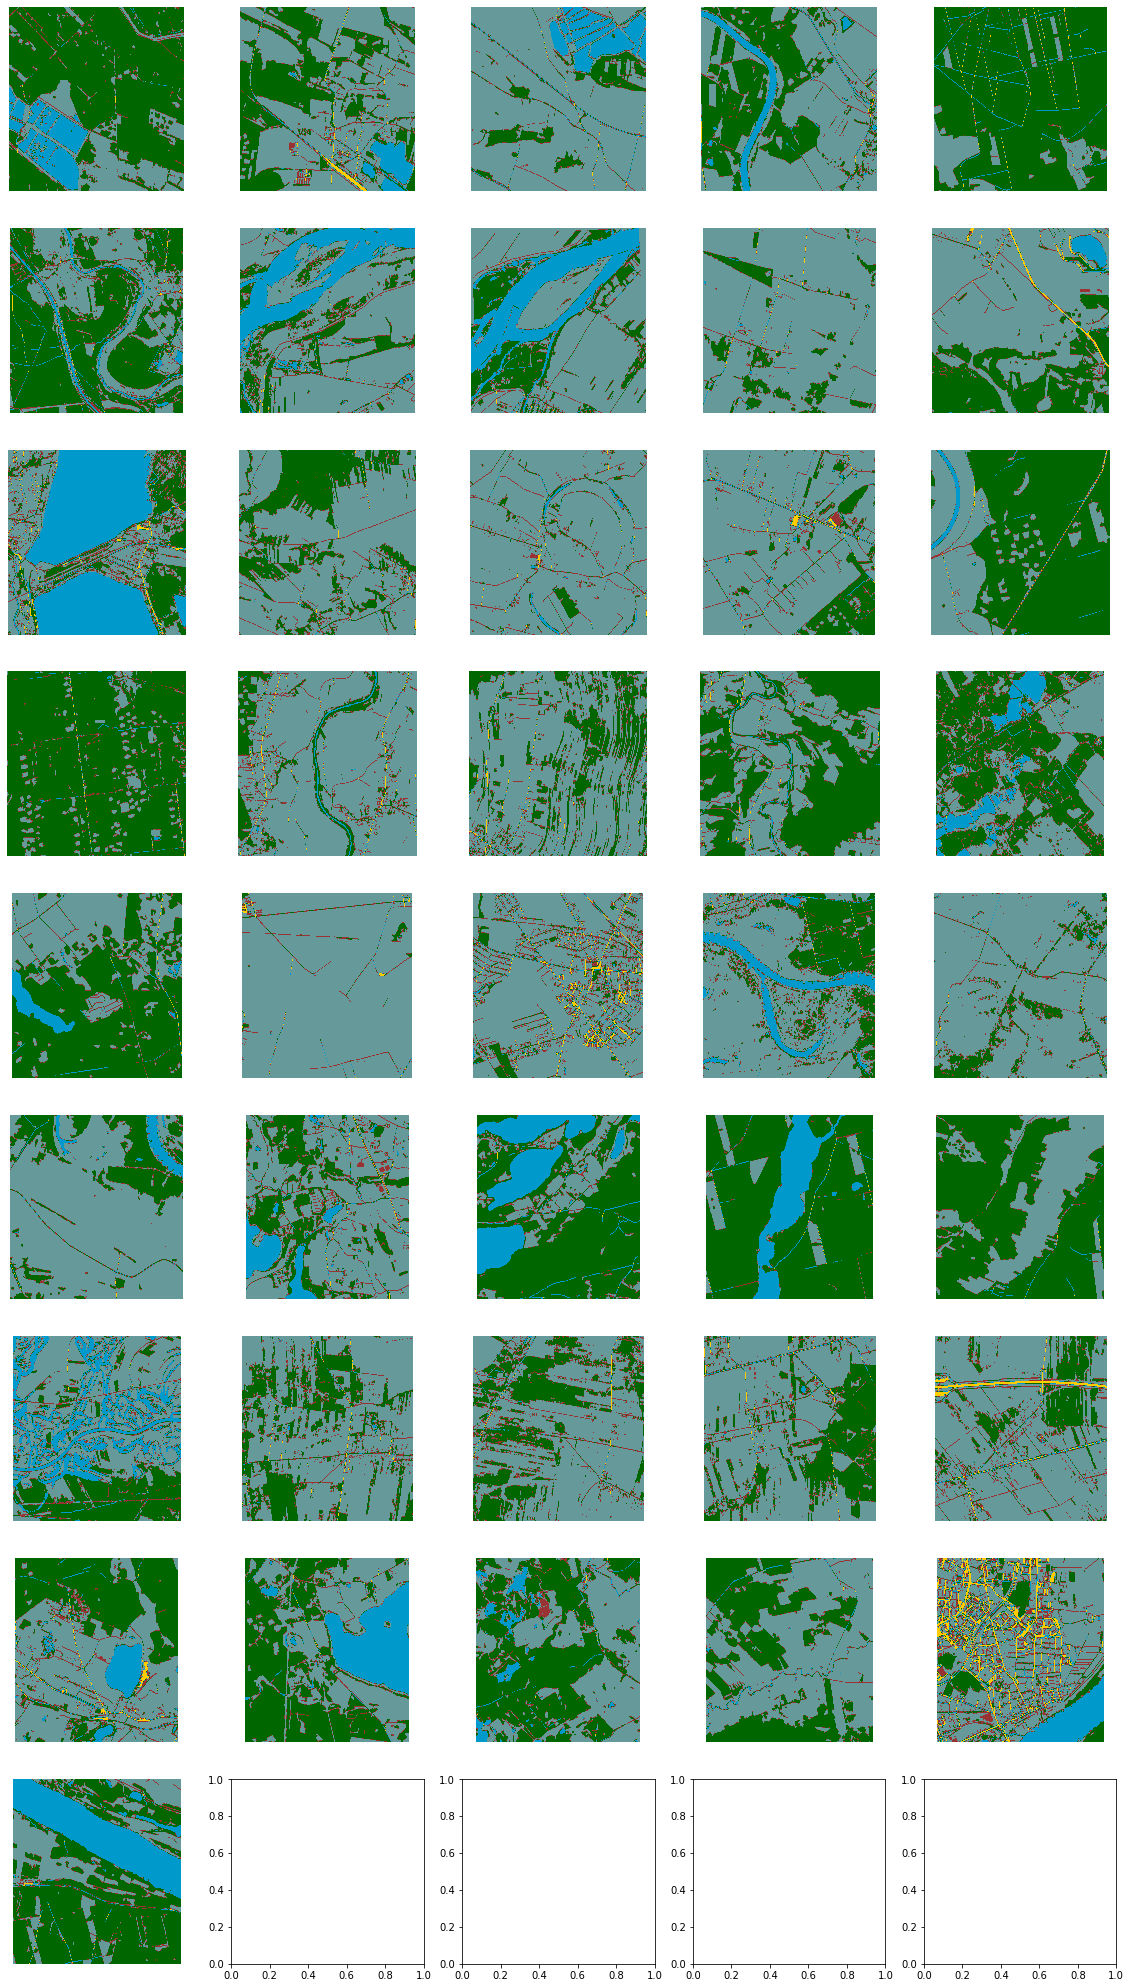

In [ ]:
# Plot mask 
plot_images_from_dir(image_dir = mask_dir, mode = 0)

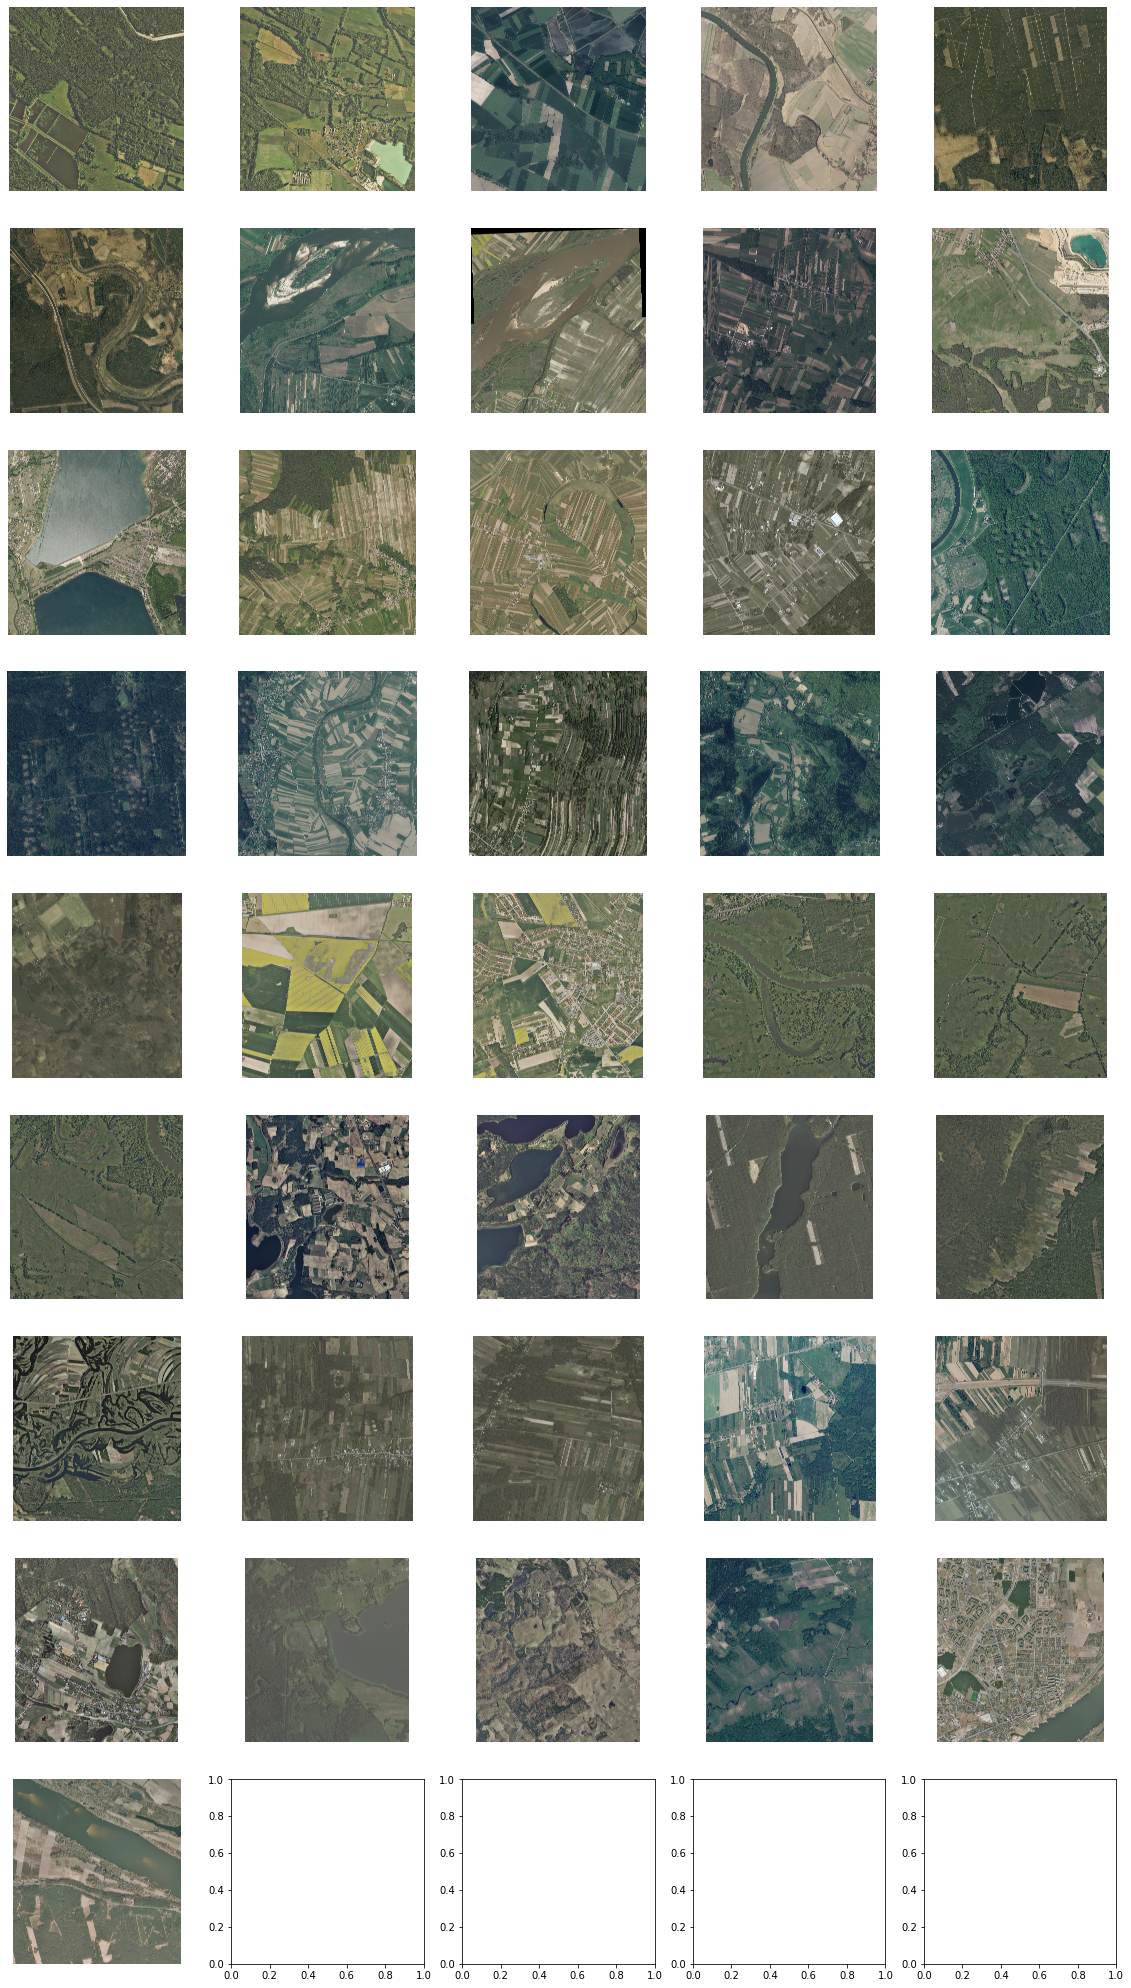

In [ ]:
# Plot image 
plot_images_from_dir(image_dir = img_dir, mode = 1)

## Get distribution of classes

In [42]:
# Original tiffs
original_class_distr = get_class_area(mask_dir, mode=0, percentage = True)
original_class_df = pd.DataFrame.from_dict(original_class_distr, orient  = 'index').reset_index().rename(columns = {'index': 'label', 0: 'area'})

Text(0, 0.5, 'Labels')

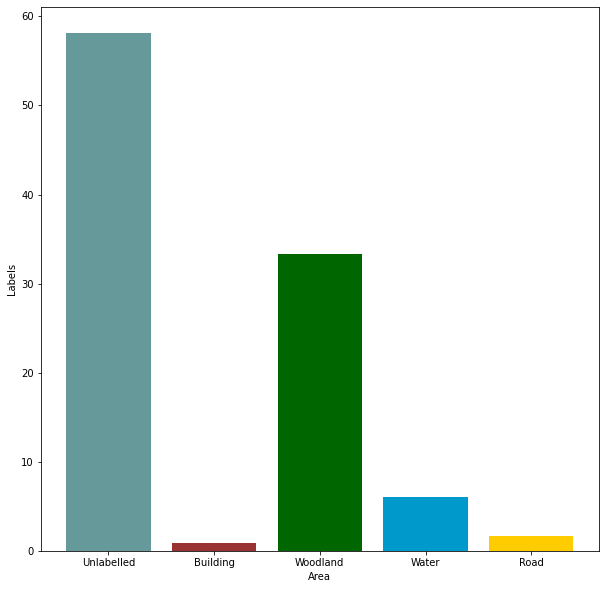

In [43]:
colors = ['#669999', '#993333', '#006600', '#0099cc', '#ffcc00']

plt.figure(figsize = (10, 10))
plt.bar(x = original_class_df['label'], height = original_class_df['area'], color = colors)
plt.xlabel('Area')
plt.ylabel('Labels')


In [45]:
# Chosen tiffs
chosen_class_distr = get_class_area(chosen_mask_dir, mode=0, percentage = True)
chosen_class_df = pd.DataFrame.from_dict(chosen_class_distr, orient  = 'index').reset_index().rename(columns = {'index': 'label', 0: 'area'})

Text(0, 0.5, 'Percentage')

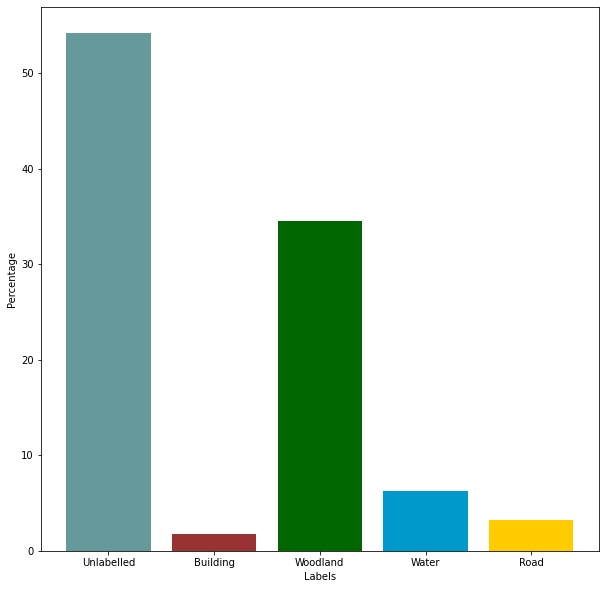

In [46]:
colors = ['#669999', '#993333', '#006600', '#0099cc', '#ffcc00']

plt.figure(figsize = (10, 10))
plt.bar(x = chosen_class_df['label'], height = chosen_class_df['area'], color = colors)
plt.xlabel('Labels')
plt.ylabel('Percentage')
